# 1. Introdução

## Predição de Preços de Casas – Kaggle House Prices 

Neste notebook utilizo o desafio **House Prices: Advanced Regression Techniques**, do Kaggle,
para prever o preço de venda de casas (`SalePrice`) utilizando técnicas simples de Machine Learning.

Aqui utilizo a biblioteca Polars no lugar de Pandas apenas por preferência pessoal,
mas o funcionamento é parecido. O importante é seguir um fluxo simples e organizado.

- Exploração inicial dos dados  
- Tratamento de valores ausentes  
- Codificação de variáveis categóricas  
- Normalização  
- Treino de um modelo simples  
- Avaliação  
- Criação do arquivo de submissão  

# 2. Imports

In [ ]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# 3. Carregando Dados

In [37]:
train = pl.read_csv("train.csv", ignore_errors=True)
test = pl.read_csv("test.csv", ignore_errors=True)

train.head()

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,…,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
i64,i64,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,i64,str,str,str,str,str,str,str,i64,str,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,i64,str,str,str,str,i64,i64,str,str,str,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,i64,str,str,i64
1,60,"""RL""","""65""",8450,"""Pave""","""NA""","""Reg""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""CollgCr""","""Norm""","""Norm""","""1Fam""","""2Story""",7,5,2003,2003,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""BrkFace""",196,"""Gd""","""TA""","""PConc""","""Gd""","""TA""","""No""","""GLQ""",706,"""Unf""",0,…,854,0,1710,1,0,2,1,3,1,"""Gd""",8,"""Typ""",0,"""NA""","""Attchd""","""2003""","""RFn""",2,548,"""TA""","""TA""","""Y""",0,61,0,0,0,0,"""NA""","""NA""","""NA""",0,2,2008,"""WD""","""Normal""",208500
2,20,"""RL""","""80""",9600,"""Pave""","""NA""","""Reg""","""Lvl""","""AllPub""","""FR2""","""Gtl""","""Veenker""","""Feedr""","""Norm""","""1Fam""","""1Story""",6,8,1976,1976,"""Gable""","""CompShg""","""MetalSd""","""MetalSd""","""None""",0,"""TA""","""TA""","""CBlock""","""Gd""","""TA""","""Gd""","""ALQ""",978,"""Unf""",0,…,0,0,1262,0,1,2,0,3,1,"""TA""",6,"""Typ""",1,"""TA""","""Attchd""","""1976""","""RFn""",2,460,"""TA""","""TA""","""Y""",298,0,0,0,0,0,"""NA""","""NA""","""NA""",0,5,2007,"""WD""","""Normal""",181500
3,60,"""RL""","""68""",11250,"""Pave""","""NA""","""IR1""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""CollgCr""","""Norm""","""Norm""","""1Fam""","""2Story""",7,5,2001,2002,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""BrkFace""",162,"""Gd""","""TA""","""PConc""","""Gd""","""TA""","""Mn""","""GLQ""",486,"""Unf""",0,…,866,0,1786,1,0,2,1,3,1,"""Gd""",6,"""Typ""",1,"""TA""","""Attchd""","""2001""","""RFn""",2,608,"""TA""","""TA""","""Y""",0,42,0,0,0,0,"""NA""","""NA""","""NA""",0,9,2008,"""WD""","""Normal""",223500
4,70,"""RL""","""60""",9550,"""Pave""","""NA""","""IR1""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""Crawfor""","""Norm""","""Norm""","""1Fam""","""2Story""",7,5,1915,1970,"""Gable""","""CompShg""","""Wd Sdng""","""Wd Shng""","""None""",0,"""TA""","""TA""","""BrkTil""","""TA""","""Gd""","""No""","""ALQ""",216,"""Unf""",0,…,756,0,1717,1,0,1,0,3,1,"""Gd""",7,"""Typ""",1,"""Gd""","""Detchd""","""1998""","""Unf""",3,642,"""TA""","""TA""","""Y""",0,35,272,0,0,0,"""NA""","""NA""","""NA""",0,2,2006,"""WD""","""Abnorml""",140000
5,60,"""RL""","""84""",14260,"""Pave""","""NA""","""IR1""","""Lvl""","""AllPub""","""FR2""","""Gtl""","""NoRidge""","""Norm""","""Norm""","""1Fam""","""2Story""",8,5,2000,2000,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""BrkFace""",350,"""Gd""","""TA""","""PConc""","""Gd""","""TA""","""Av""","""GLQ""",655,"""Unf""",0,…,1053,0,2198,1,0,2,1,4,1,"""Gd""",9,"""Typ""",1,"""TA""","""Attchd""","""2000""","""RFn""",3,836,"""TA""","""TA""","""Y""",192,84,0,0,0,0,"""NA""","""NA""","""NA""",0,12,2008,"""WD""","""Normal""",250000


# 4. Exploração Inicial

In [38]:
train.shape

(1460, 81)

In [ ]:
# O Polars mostra estatísticas apenas para colunas numéricas.
# Colunas categóricas aparecem com 'null' nas métricas estatísticas, o que é normal.
train.describe()

statistic,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,…,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
str,f64,f64,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,str,str,str,str,str,f64,str,str,str,str,str,str,str,f64,str,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str,f64,str,str,str,str,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,str,str,str,f64,f64,f64,str,str,f64
"""count""",1460.0,1460.0,"""1460""","""1460""",1460.0,"""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""",1460.0,1460.0,1460.0,1460.0,"""1460""","""1460""","""1460""","""1460""","""1460""",1452.0,"""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""",1460.0,"""1460""",…,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,"""1460""",1460.0,"""1460""",1460.0,"""1460""","""1460""","""1460""","""1460""",1460.0,1460.0,"""1460""","""1460""","""1460""",1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,"""1460""","""1460""","""1460""",1460.0,1460.0,1460.0,"""1460""","""1460""",1460.0
"""null_count""",0.0,0.0,"""0""","""0""",0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0""","""0""",8.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""",…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,"""0""","""0""","""0""","""0""",0.0,0.0,"""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""","""0""",0.0,0.0,0.0,"""0""","""0""",0.0
"""mean""",730.5,56.89726,null,null,10516.828082,null,null,null,null,null,null,null,null,null,null,null,null,6.099315,5.575342,1971.267808,1984.865753,null,null,null,null,null,103.685262,null,null,null,null,null,null,null,443.639726,null,…,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,null,6.517808,null,0.613014,null,null,null,null,1.767123,472.980137,null,null,null,94.244521,46.660274,21.95411,3.409589,15.060959,2.758904,null,null,null,43.489041,6.321918,2007.815753,null,null,180921.19589
"""std""",421.610009,42.300571,null,null,9981.264932,null,null,null,null,null,null,null,null,null,null,null,null,1.382997,1.112799,30.202904,20.645407,null,null,null,null,null,181.066207,null,null,null,null,null,null,null,456.098091,null,…,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,null,1.625393,null,0.644666,null,null,null,null,0.747315,213.804841,null,null,null,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,null,null,null,496.123024,2.703626,1.328095,null,null,79442.502883
"""min""",1.0,20.0,"""C (all)""","""100""",1300.0,"""Grvl""","""Grvl""","""IR1""","""Bnk""","""AllPub""","""Corner""","""Gtl""","""Blmngtn""","""Artery""","""Artery""","""1Fam""","""1.5Fin""",1.0,1.0,1872.0,1950.0,"""Flat""","""ClyTile""","""AsbShng""","""AsbShng""","""BrkCmn""",0.0,"""Ex""","""Ex""","""BrkTil""","""Ex""","""Fa""","""Av""","""ALQ""",0.0,"""ALQ""",…,0.0,0.0,334.0,0.0,0.0,0.0,0.0,0.0,0.0,"""Ex""",2.0,"""Maj1""",0.0,"""Ex""","""2Types""","""1900""","""Fin""",0.0,0.0,"""Ex""","""Ex""","""N""",0.0,0.0,0.0,0.0,0.0,0.0,"""Ex""","""GdPrv""","""Gar2""",0.0,1.0,2006.0,"""COD""","""Abnorml""",34900.0
"""25%""",366.0,20.0,null,null,7558.0,null,null,null,null,null,null

In [40]:
nulls = train.null_count().transpose()
nulls.columns = ["null_count"]
nulls = nulls.sort("null_count", descending=True)
nulls.head(20)

null_count
u32
8
0
0
0
0
…
0
0
0


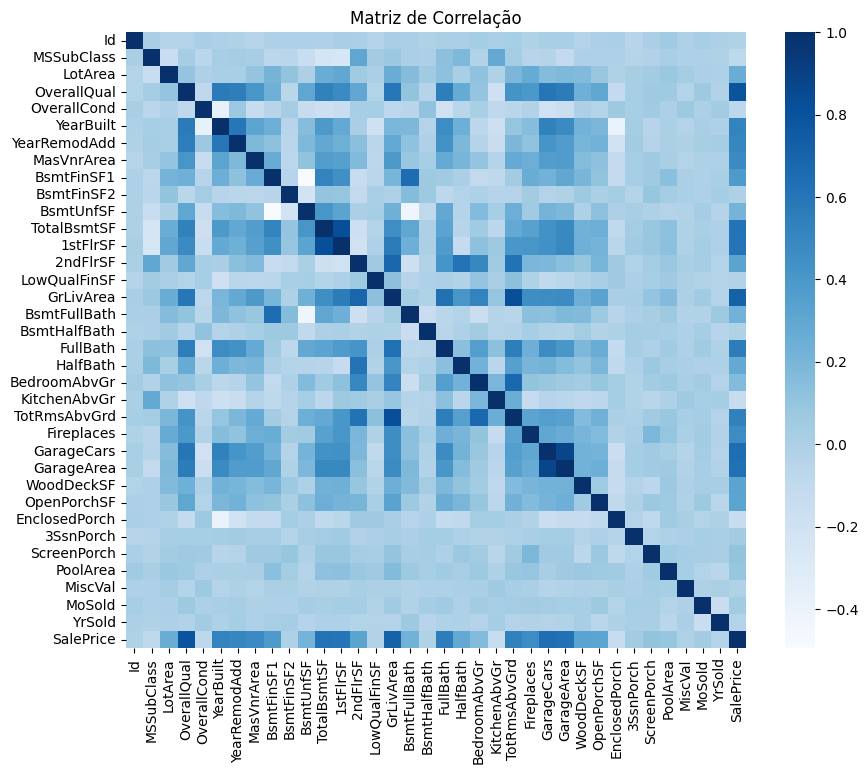

In [ ]:
# O Polars não possui uma função de correlação em matriz diretamente compatível com o Seaborn,
# então converto temporariamente para pandas apenas para visualizar o heatmap.
corr = train.to_pandas().corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="Blues")
plt.title("Matriz de Correlação")
plt.show()

# 5. Separando Variáveis

In [42]:
y = train["SalePrice"]
X = train.drop("SalePrice")

## 6. Juntando treino e teste

Aqui junto o conjunto de treino (sem a coluna SalePrice) com o conjunto de teste.
Isso facilita o pré-processamento, pois consigo tratar valores ausentes e transformar
as variáveis categóricas de uma vez só, mantendo a consistência entre os dois conjuntos.

In [43]:
full = pl.concat([X, test], how="vertical")
full.shape

(2919, 80)

# 7. Tratamento de Dados

### **Tratando valores ausentes em variáveis numéricas**
Para as colunas numéricas, substituo valores ausentes pela mediana.  
A mediana é uma escolha simples e robusta, evitando que valores extremos
afetem o resultado do preenchimento. Essa é uma estratégia comum em
problemas de regressão com dados tabulares.

### **Tratando valores ausentes em variáveis categóricas**
As colunas categóricas (texto) recebem a moda, ou seja, o valor mais frequente.
Essa técnica é bastante utilizada porque mantém a categoria mais representativa
no conjunto de dados, evitando criar valores artificiais.


In [44]:
num_cols = [col for col, dtype in full.schema.items() if dtype in (pl.Float64, pl.Int64)]

for col in num_cols:
    mediana = full[col].median()
    full = full.with_columns(
        pl.col(col).fill_null(mediana)
    )

In [45]:
cat_cols = [col for col, dtype in full.schema.items() if dtype == pl.Utf8]

for col in cat_cols:
    moda = full[col].mode().item() if full[col].mode().shape[0] > 0 else "None"
    full = full.with_columns(
        pl.col(col).fill_null(moda)
    )

## 8. Transformando variáveis categóricas em variáveis numéricas

Modelos de Machine Learning não conseguem trabalhar diretamente com textos.
Por isso, transformo cada coluna categórica em várias colunas 0/1 usando
One-Hot Encoding. Dessa forma, cada categoria vira uma nova coluna indicando
a presença (1) ou ausência (0) daquela categoria.

In [46]:
full = full.to_dummies(columns=cat_cols)

## 9. Separando novamente treino e teste

Depois de aplicar todas as transformações, separo novamente os dados.
As primeiras linhas pertencem ao conjunto de treino e o restante ao conjunto
de teste, mantendo o alinhamento correto para gerar as previsões depois.

In [47]:
X = full[:len(train)]
X_test_final = full[len(train):]

## 10. Divisão em treino e validação

Aqui separo os dados em duas partes:  
- **Treino (80%)**: usado para ajustar o modelo  
- **Validação (20%)**: usado para avaliar o desempenho antes de testar no conjunto oficial

Esse processo é importante para evitar overfitting e verificar se o modelo está
conseguindo generalizar para dados novos.

In [48]:
X_np = X.to_numpy()
y_np = y.to_numpy()

X_train, X_val, y_train, y_val = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42
)

## 11. Treinando o modelo

Utilizo aqui um modelo de Regressão Linear simples.  
Esse modelo é fácil de interpretar e costuma funcionar bem como primeira abordagem
para problemas de regressão com dados tabulares.

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_val)

## 12. Avaliação do modelo

Utilizo duas métricas comuns em problemas de regressão:

- **MAE (Mean Absolute Error)**: erro médio em valor absoluto.  
  Diz, em média, o quanto o modelo erra o preço das casas.

- **RMSE (Root Mean Squared Error)**: penaliza erros grandes com mais força.  
  É útil para entender o impacto dos desvios maiores.

Valores menores indicam melhor desempenho.


In [50]:
mae = mean_absolute_error(y_val, preds)
rmse = np.sqrt(mean_squared_error(y_val, preds))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 21697.671967916613
RMSE: 44909.52269051501


## 13. Treinando o modelo final

Após avaliar o modelo, treino novamente usando **todos os dados de treino** disponíveis,
garantindo que o modelo utilize o máximo de informação possível antes de gerar as
previsões para o conjunto de teste oficial do Kaggle.

In [51]:
# Treinando o modelo final com todos os dados de treino
final_model = LinearRegression()
final_model.fit(X_np, y_np)

# Gerando previsões para o conjunto de teste
test_preds = final_model.predict(X_test_final.to_numpy())

Além das métricas MAE e RMSE, também calculo o **R²**, que indica o quanto da
variação do preço das casas o modelo consegue explicar. Valores próximos de 1
indicam melhor ajuste, enquanto valores mais baixos indicam que parte da
variação não foi capturada pelo modelo.

In [ ]:
r2 = r2_score(y_val, preds)
print("R²:", r2)

R²: 0.7370561337534678


## 14. Conclusão

Ao longo deste notebook apliquei um fluxo simples de Machine Learning para o desafio *House Prices* do
Kaggle, utilizando a biblioteca Polars para manipulação dos dados e um modelo básico de Regressão Linear.

O processo envolveu:

- uma exploração inicial para identificar a estrutura e características do conjunto de dados  
- tratamento de valores ausentes de forma consistente (mediana para variáveis numéricas e moda para categóricas)  
- transformação das variáveis categóricas em representações numéricas por meio de one-hot encoding  
- divisão dos dados em treino e validação para avaliar o desempenho do modelo  
- treinamento e avaliação de um modelo de Regressão Linear utilizando MAE, RMSE e R²  
- geração do arquivo de submissão compatível com a plataforma do Kaggle  

Embora simples, o pipeline apresentado é totalmente funcional e demonstra de forma clara os principais
passos necessários em um projeto de regressão: desde o pré-processamento dos dados até a produção do
resultado final.
